In [1]:
import itertools
import numpy as np
from pymatgen import Structure
from pymatgen import Lattice
from pyxtal.symmetry import get_wyckoffs
from tqdm.notebook import tqdm
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from scipy.optimize import linear_sum_assignment
import numpy as np
import pandas as pd
import GPy
from matplotlib import pyplot as plt
from numpy.random import randn
import warnings

from monty.serialization import loadfn, dumpfn

from pandas import DataFrame
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import os
from camd.experiment.dft import *
%matplotlib inline
import pandas as pd
from camd.agent.generic import GPBatchUCB
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import camd
from camd.agent.base import RandomAgent
from camd.agent.generic import GenericGPUCB
from camd.analysis import GenericMaxAnalyzer
from camd.experiment import ATFSampler
from camd.campaigns.base import Campaign
path = os.getcwd()

import pickle
from tqdm.notebook import tqdm
from pymatgen.analysis.diffraction import xrd
from pymatgen import MPRester
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from pymatgen import Lattice
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects
mpr = MPRester('xpFvqo6ae6RNF3rqM0WI')
    

# Setup Data


In [2]:
scores = loadfn('scores-mp-7648-density=1.7.json')
struc_coords = loadfn('struc_coords-mp-7648-density=1.7.json')
rvalues=loadfn('rvalues-mp-7648-density=1.7.json')
energies=loadfn('energies-mp-7648-density=1.7.json')

In [3]:
mpid = 'mp-7648'
# density = 2

original_str = SpacegroupAnalyzer(mpr.get_structure_by_material_id(mpid)).get_conventional_standard_structure()

# SETUP
spg = SpacegroupAnalyzer(original_str).get_symmetry_dataset()['number']
a=original_str.lattice.a ; b=original_str.lattice.b; c=original_str.lattice.c 
alpha=original_str.lattice.alpha; beta=original_str.lattice.beta; gamma=original_str.lattice.gamma
print(spg,a,b,c,alpha,beta,gamma)
tracker = {}
for specie in original_str.species:
    if specie.as_dict()['element'] not in tracker:
        tracker[specie.as_dict()['element']] = 1
    else:
        tracker[specie.as_dict()['element']] += 1

atoms = [(tracker[key], key) for key in tracker]

sorteddict = list(reversed(sorted(tracker)))

species = []
for specie in sorteddict:
    for num in range(tracker[specie]):
        species.append(specie) 

20 5.088538 9.138582 8.334435 90.0 90.0 90.0


In [4]:
configuration = 0

scores = scores[configuration]
struc_coords = struc_coords[configuration]
rvalues = rvalues[configuration]
energies = energies[configuration]

In [5]:
strucs = []
lattice = Lattice.from_parameters(a,b,c,alpha,beta,gamma)

for m in range(len(struc_coords)):
    sites = []
    for j in list(struc_coords[m]):
        for k in j:
            sites.append(k)
    strucs.append(Structure(lattice, species, sites))
print(species,atoms)

['Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'] [(8, 'Si'), (16, 'O')]


In [6]:
data = []
index = [[0,[0,1,2]],[8,[0,1,2]],[16,[1]],[20,[0]]]
for i in range(len(scores)):
    
    if scores[i] == None:
        continue
    x =[]
    for coord in index:
        for xyz in coord[1]:
            x.append(strucs[i].frac_coords[coord[0]][xyz])
   
    x.append(rvalues[i])
    x.append(-1*energies[i])
#     x.append(None)
    x.append(strucs[i])
    data.append(x)



In [22]:
df2 = df.copy()

In [23]:
df3 = df2.sort_values(by= 'target')

In [24]:
len(df3)

111198

In [27]:
df3.iloc[int(111198*0.99)]

1x                                                       0.125
1y                                                    0.166667
1z                                                    0.466667
2x                                                       0.375
2y                                                        0.25
2z                                                         0.6
3y                                                           0
4x                                                        0.25
R                                                      41.4337
target                                                 104.183
structure    [[0.63606725 1.523097   3.889403  ] Si, [4.452...
Name: 58711, dtype: object

In [7]:
indexes = []
for i in range(len(data)):
    indexes.append(str(i))
    
df = DataFrame(data, index=indexes, columns = ['1x','1y','1z','2x','2y','2z','3y','4x', 'R', 'target', 'structure'])
df = df.loc[df['R']< 30]

df = df.sample(frac=1)

In [37]:
dfs = []
for rvalue in [200,50,40,30,25, 20]:
    dfs.append(df.loc[df['R']< rvalue].copy().drop(["R",'structure'],axis=1))

In [8]:
MLP_kern = GPy.kern.MLP(8)
RBF_kern = GPy.kern.RBF(8, lengthscale = 0.6)
per_kern = GPy.kern.StdPeriodic(8)

In [39]:
def random_campaign(i):
    loop_dir = os.path.join(path,'policy-random-{}-si-500'.format(i))
    os.mkdir(loop_dir)
    N_query = 1  # This many experiments are requested in each iteration
    N_seed = 100  # This many samples are randomly acquired in the beginning to form a seed.
    agent = RandomAgent(n_query=N_query)
    analyzer = GenericMaxAnalyzer(threshold=104.183)
    experiment = ATFSampler(df)
    candidate_data = df
    loop = Campaign(candidate_data, agent, experiment, analyzer,path=loop_dir,create_seed=N_seed)
    loop.initialize(random_state=i)
    loop.auto_loop(n_iterations=500)
    return loop.analyzer.score 

In [33]:
### Implement agent here
from camd.agent.base import HypothesisAgent
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

class RFAgent(HypothesisAgent):
    def __init__(self, n_query = 1):
        self.n_query = n_query
        
    def get_hypotheses(self, candidate_data, seed_data):
        # Fit on known data
        x_known = seed_data.get(['1x','1y','1z','2x','2y','2z','3y','4x']).values.tolist()
        y_known = seed_data.get('target').values.tolist()
        regressor = RandomForestRegressor(n_estimators=10)
        regressor.fit(x_known, y_known)
        
        # Predict unknown data
        x_unknown = candidate_data.get(['1x','1y','1z','2x','2y','2z','3y','4x']).values.tolist()
        y_predicted = regressor.predict(x_unknown)
        
        # Pick top 5 candidates
        candidate_data['energy_pred'] = y_predicted
        candidate_data = candidate_data.sort_values(
            'energy_pred', ascending=False)
        top_candidates = candidate_data.head(self.n_query)
        return top_candidates
    


In [34]:
class LinearAgent(HypothesisAgent):
    def __init__(self, n_query = 1):
        self.n_query = n_query
    def get_hypotheses(self, candidate_data, seed_data):
        # Fit on known data
        x_known = seed_data.get(['1x','1y','1z','2x','2y','2z','3y','4x']).values.tolist()
        y_known = seed_data.get('target').values.tolist()
        regressor = LinearRegression()
        regressor.fit(x_known, y_known)
        
        # Predict unknown data
        x_unknown = candidate_data.get(['1x','1y','1z','2x','2y','2z','3y','4x']).values.tolist()
        y_predicted = regressor.predict(x_unknown)
        
        # Pick top 5 candidates
        candidate_data['energy_pred'] = y_predicted
        candidate_data = candidate_data.sort_values(
            'energy_pred', ascending=False)
        top_candidates = candidate_data.head(self.n_query)
        return top_candidates

In [37]:
def RF_campaign(i):
    loop_dir = os.path.join(path,'policy-RF-{}-si-500'.format(i))
    os.mkdir(loop_dir)
    N_query = 1  # This many experiments are requested in each iteration
    N_seed = 100  # This many samples are randomly acquired in the beginning to form a seed.
    agent = RFAgent(n_query=N_query)
    analyzer = GenericMaxAnalyzer(threshold=104.183)
    experiment = ATFSampler(df)
    candidate_data = df
    loop = Campaign(candidate_data, agent, experiment, analyzer,path=loop_dir,create_seed=N_seed)
    loop.initialize(random_state=i)
    loop.auto_loop(n_iterations=500)
    return loop.analyzer.score 

In [38]:
def Linear_campaign(i):
    loop_dir = os.path.join(path,'policy-Linear-{}-si-500'.format(i))
    os.mkdir(loop_dir)
    N_query = 1  # This many experiments are requested in each iteration
    N_seed = 100  # This many samples are randomly acquired in the beginning to form a seed.
    agent = LinearAgent(n_query=N_query)
    analyzer = GenericMaxAnalyzer(threshold=104.183)
    experiment = ATFSampler(df)
    candidate_data = df
    loop = Campaign(candidate_data, agent, experiment, analyzer,path=loop_dir,create_seed=N_seed)
    loop.initialize(random_state=i)
    loop.auto_loop(n_iterations=500)
    return loop.analyzer.score 

In [14]:
@wrap_non_picklable_objects
def gp_campaign(i,n_query,max_budget):
    loop_dir = os.path.join(path,'GP-SiO2-100seed-500exp-{}-{}'.format(n_query,i))
    os.mkdir(loop_dir)
    N_seed = 100  # This many samples are randomly acquired in the beginning to form a seed.
    agent = GPBatchUCB(n_query=n_query, mode='batch', alpha='auto', kernel=RBF_kern+per_kern, features = ['1x','1y','1z','2x','2y','2z','3y','4x', 'target'])
    analyzer = GenericMaxAnalyzer(threshold=104.183)
    experiment = ATFSampler(df)
#     experiment = OqmdDFTonMC1(poll_time=20, timeout=7200)
    candidate_data = df
    loop = Campaign(candidate_data, agent, experiment, analyzer,
                    path=loop_dir,create_seed=N_seed)
    loop.initialize(random_state=i)
    loop.auto_loop(n_iterations=max_budget/n_query)
    return loop.analyzer.score 

In [18]:
df.head()

,1x,1y,1z,2x,2y,2z,3y,4x,R,target,structure
68836,0.875,0.000000,0.833333,0.375,0.000000,0.133333,0.500000,0.250,37.401215,22.442416,"[[4.45247075 0. 6.9453625 ] Si, [4.452..."
102554,0.500,0.166667,0.933333,0.250,0.083333,0.666667,0.916667,0.250,26.293797,93.143996,"[[2.544269 1.523097 7.778806] Si, [2.544269 1..."
94158,0.000,0.083333,0.933333,0.750,0.583333,0.200000,0.666667,0.250,41.083534,40.939756,[[-4.66313966e-17 7.61548500e-01 7.77880600e...
63697,0.750,0.000000,0.700000,0.125,0.666667,0.500000,0.916667,0.375,40.142384,38.742767,"[[3.8164035 0. 5.8341045] Si, [1.272134..."
46922,0.250,0.250000,0.200000,0.750,0.416667,0.866667,0.083333,0.250,70.614362,83.573305,"[[1.2721345 2.2846455 1.666887 ] Si, [3.816403..."


In [ ]:
RF_results = Parallel(n_jobs=5)(delayed(RF_campaign)(i) for i in range(5))
Linear_results = Parallel(n_jobs=5)(delayed(Linear_campaign)(i) for i in range(5))
random_results = Parallel(n_jobs=5)(delayed(random_campaign)(i) for i in range(5))

In [50]:
dumpfn(RF_results, 'RF_results.json')
dumpfn(Linear_results, 'Linear_results.json')
dumpfn(random_results, 'random_results.json')

In [17]:
RF_results = loadfn('RF_results.json')
Linear_results = loadfn('Linear_results.json')
random_results = loadfn('random_results.json')

In [ ]:
alpha_runs1 = []
# for n_query in [1]:
for dataframe in dfs:
    gp_results = Parallel(n_jobs=-1)(delayed(gp_campaign)(i,1, 100, dataframe) for i in range(10))
    alpha_runs1.append(gp_results)

In [15]:
alpha_runs3 = []
for n_query in [1,3,5,10,20]:
# for dataframe in dfs:
    gp_results = Parallel(n_jobs=5)(delayed(gp_campaign)(i,n_query, 500) for i in range(5))
    alpha_runs3.append(gp_results)

 /opt/miniconda3/envs/python37/lib/python3.7/site-packages/joblib-0.16.0-py3.7.egg/joblib/externals/loky/process_executor.py:691: UserWarning:A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


In [29]:
len(alpha_runs2)

6

In [28]:
alpha_runs2 = []
for seed in [10,30,50,100,200,500]:
# for dataframe in dfs:
    gp_results = Parallel(n_jobs=5)(delayed(gp_campaign)(i,1, 100, seed) for i in range(10))
    alpha_runs2.append(gp_results)

 /opt/miniconda3/envs/python37/lib/python3.7/site-packages/joblib-0.16.0-py3.7.egg/joblib/externals/loky/process_executor.py:691: UserWarning:A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

In [33]:
dumpfn(alpha_runs2, 'gpseedruns-100experiments.json')

In [4]:
alpha_runs2 = loadfn('gpseedruns-100experiments.json')

In [34]:
alpha_runs3 = []
for seed in [100]:
# for dataframe in dfs:
    gp_results = Parallel(n_jobs=5)(delayed(gp_campaign)(i,5, 500) for i in range(5))
    alpha_runs3.append(gp_results)

 /opt/miniconda3/envs/python37/lib/python3.7/site-packages/joblib-0.16.0-py3.7.egg/joblib/externals/loky/process_executor.py:691: UserWarning:A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


KeyboardInterrupt: 

In [39]:
dumpfn(alpha_runs1, 'gprvaluesruns-100seed-100experiments.json')

In [20]:
dumpfn(alpha_runs1, 'gpbatchruns-100seed-100experiments.json')

In [32]:
alpha_runs1 = loadfn('gprvaluesruns-100seed-100experiments.json')

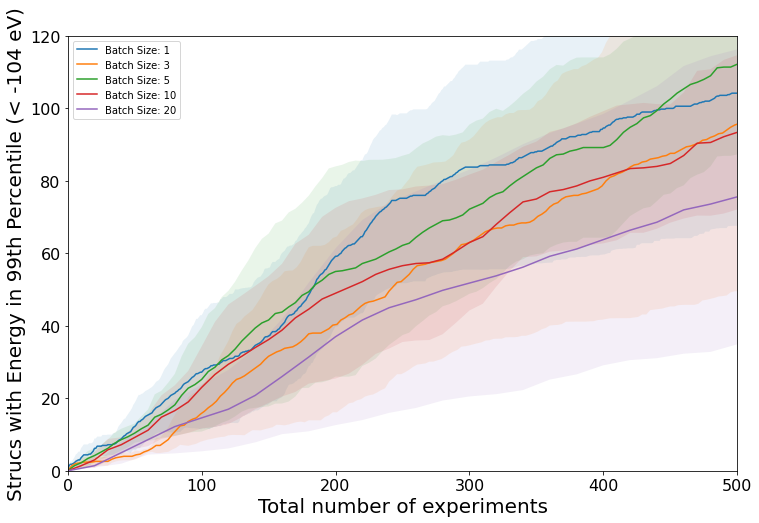

In [43]:
# q = ['All R', 'R<50','R < 40', 'R < 30', 'R < 25', 'R < 20']
q = [1,3,5,10,20]
plt.figure(figsize = [12,8])
for i in range(5):
    
    merged1 = np.array([j for j in alpha_runs3[i]])
    mu1 = np.mean(merged1, axis=0)
    std1 = np.std(merged1, axis=0)
    x1 = np.arange(0,len(merged1[0])+1)* q[i]
    merged1 = np.insert(merged1,0,0)
    std1 = np.insert(std1,0,0)
    mu1 = np.insert(mu1,0,0)
    plt.fill_between(x1, (mu1+std1), (mu1-std1), alpha=0.1)
    plt.plot(x1 ,mu1, label='Batch Size: '+ str(q[i]))

# merged1 = np.array([j for j in random_results])
# mu1 = np.mean(merged1, axis=0)
# std1 = np.std(merged1, axis=0)
# x1 = np.arange(0,len(merged1[0])+1)* 5
# merged1 = np.insert(merged1,0,0)
# std1 = np.insert(std1,0,0)
# mu1 = np.insert(mu1,0,0)
# plt.fill_between(x1, mu1+std1, mu1-std1, alpha=0.1)
# plt.plot(x1 ,mu1, label='random')

# merged2 = np.array([j for j in RF_results])
# mul2 = np.mean(merged2, axis=0)
# std2 = np.std(merged2, axis=0)
# x2 = np.arange(0,len(merged2[0])+1)* 5
# merged2 = np.insert(merged2,0,0)
# std2 = np.insert(std2,0,0)
# mul2 = np.insert(mul2,0,0)
# plt.fill_between(x2, mul2+std2, mu1-std2, alpha=0.1)
# plt.plot(x2, mul2, label='Random-Forest')


# merged3 = np.array([j for j in Linear_results])
# mul3 = np.mean(merged3, axis=0)
# std3 = np.std(merged3, axis=0)
# x3 = np.arange(0,len(merged3[0])+1)* 5
# merged3 = np.insert(merged3,0,0)
# std3 = np.insert(std3,0,0)
# mul3 = np.insert(mul3,0,0)
# plt.fill_between(x3, mul3+std3, mu1-std3, alpha=0.1)
# plt.plot(x3, mul3, label='Linear')

# plt.plot([0,120],[12,12],'k--')
# plt.title('Multiphase Nanoparticle Discovery [D:148,Seed:10]')
plt.xlim(0,500)
plt.ylim(0,120)
plt.ylabel("Strucs with Energy in 99th Percentile (< -104 eV)",fontsize = 20)
plt.xlabel("Total number of experiments",fontsize = 20)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.legend()

In [40]:
lendfs = []
for j in range(len(dfs)):
    count = 0
    for i in range(len(dfs[j])):
        if dfs[j].iloc[i]['target'] > 120:
            count += 1
    lendfs.append(count)

In [20]:
lendfs

[74, 72, 48, 40, 32, 24]